## Final Project: House Prices Prediction
https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

#### Team MLAIRE: Chi Iong Ansjory, Prabhat Tripathi, Soodong Kim, Tina Agarwal

Sections:
- [1. Introduction](#Introduction)
- [2. Import Libraries](#import_libraries)
- [3. Data Loading](#data_loading)
- [4. Exploratory Data Analysis](#eda)
- [5. Feature Engineering](#feature_engineering)
- [6. Modeling](#modeling)
- [7. Summary & Key Results](#summary)
- [8. References](#references)



<a id='Introduction'></a>
# 1. Introduction

The goal of this project is to predict sale price of residential homes in Ames, Iowa based on the given training and test data sets. There are 79 explanatory variables describing different aspects of residential homes with 1,460 observations in both training and test data sets. 

The output variable (*SalePrice*) is numeric (interval) whereas the explanatory (LHS) variables are a combination of numeric (interval) and categorical variables. 

Considering the size and nature of the data set, and informed by our domain understanding, we believe that *feature engineering* -- crafting data features optimized for machine learning -- is key for better modeling for this problem. Specifically, we plan to perform following:

1. Load data, perform sanity check and fix any obvious data errors.  
2. Perform exploratory data analysis (EDA) on the train data. This includes univariate and bivariate analysis of  explanatory features to understand their relationships with the output variable *SalePrice*.  
3. Feature Engineering  
   - Missing values and their appropriate imputation.  
   - Transformation of features and feature scaling, if needed.  
   - Encodings to convert categorical features into numerical features so that we can run regression models.  
   - Split train and dev data sets.  
4. Modeling  
   - We will try running several regression models and compare them for their prediction results. We will choose the best model or an ensamble of candidate models for final prediction. We also have to watch out for overfitting considering there are a large number of input variables (compared to the training data size).  
5. Summarize the key findings.  

<a id='import_libraries'></a>
# 2. Import Libraries

We import necessary libraries such as sklearn, scipy, pandas, numpy, and seaborn.

In [260]:
# Each plot will not open a new window
%matplotlib inline

# Python fundamental libraries
import os
import time
from collections import defaultdict
from IPython.display import Image

# Import relevant libraries

# Top level libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# SK-learn libraries for projection/learning
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

# SK-learn libraries for data mangling
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

# SK-learn libraries for clustering experiment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Scipy libraries
from scipy.stats import norm
from scipy import stats

# Disable warnings for more clear output
import warnings 
warnings.filterwarnings('ignore')

<a id='data_loading'></a>
# 3. Data Loading

## Import Data

We import both train and test data from csv files, make copies of both, and display the origin shapes of them.

In [261]:
# Load data
# Please keep this relative path access to data
dir_name = os.getcwd()
train_filename = os.path.join(dir_name, 'data/train.csv')
test_filename = os.path.join(dir_name, 'data/test.csv')

# Reading the data
train = pd.read_csv(train_filename)
test  = pd.read_csv(test_filename)

# We copy and preserve the original data frames for reference
train_orig = train.copy()
test_orig = test.copy()

print("Original shapes of train and test datasets:")
train.shape, test.shape

Original shapes of train and test datasets:


((1460, 81), (1459, 80))

<a id='eda'></a>
# 4. Exploratory Data Analysis

Following hyperlinks direct to relevant subsections:
- [Feature Overview](#feature_overview)
- [Numeric Features](#numeric_features)
- [Categorical Features](#categorical_features)
- [Feature Summary](#features_summary)
- [Univariate Analysis](#univariate_analysis)
    - [SalePrice](#saleprice)
    - [GrLivArea](#grlivarea)
    - [LotArea](#lotarea)
    - [PoolArea](#poolarea)
    - [OverallQual](#overallqual)
    - [YearBuilt](#yearbuilt)
    - [Street and MiscFeature](#street_and_miscfeature)
    - [MiscVal](#miscval)
    - [YrSold](#yrsold)
    - [MoSold](#mosold)
- [Bivariate Analysis](#bivariate_analysis)
    - [SalePrice - GrLivArea Relationship](#saleprice_grlivarea)
    - [SalePrice - OverallQual Relationship](#saleprice_overallqual)
    - [SalePrice - YearBuilt Relationship](#saleprice_yearbuilt)
    - [SalePrice - GarageCars Relationship](#saleprice_garagecars)
    - [SalePrice - BsmtQual Relationship](#saleprice_bsmtqual)
    - [SalePrice - BsmtCond Relationship](#saleprice_bsmtcond)
    - [SalePrice - BsmtExposure Relationship](#saleprice_bsmtexposure)
    - [SalePrice - KitchenQual Relationship](#saleprice_kitchenqual)
    - [SalePrice - ExterQual Relationship](#saleprice_exterqual)
    - [SalePrice - Neighborhood Relationship](#saleprice_neighborhood)

In [262]:
# A glimpse of the data set
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<a id='feature_overview'></a>
## Feature Overview

In [263]:
# Begin with discriminating between numeric and categorical features
# (including SalePrice output variable)
numeric_columns = [f for f in train.columns if train.dtypes[f] != 'object']
category_columns = [f for f in train.columns if train.dtypes[f] == 'object']
print('Number of numeric features: {}'.format(len(numeric_columns)))
print('Number of categorical features: {}'.format(len(category_columns)))

Number of numeric features: 38
Number of categorical features: 43


<a id='numeric_features'></a>
## Numeric Features

In [264]:
# Re-identifying numeric features
numeric_columns = [f for f in train.columns if train.dtypes[f] != 'object']
print('* Number of numeric features: {}'.format(len(numeric_columns)))

# Print numeric features and some properties
print("-------------------------------- Numeric Features --------------------------------")
print(numeric_columns)
print("----------------------------------------------------------------------------------")

# We also look at numeric features that have small number of unique "discrete" values
discrete_columns = []
print("\n* Discrete features (Numeric features with small number of unique values)")
for col in numeric_columns:
    if (train[col].nunique() <= 10):
        discrete_columns.append(col)
        print ('{}: {}'.format(col, train[col].nunique()))        

* Number of numeric features: 38
-------------------------------- Numeric Features --------------------------------
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
----------------------------------------------------------------------------------

* Discrete features (Numeric features with small number of unique values)
OverallQual: 10
OverallCond: 9
BsmtFullBath: 4
BsmtHalfBath: 3
FullBath: 4
HalfBath: 3
BedroomAbvGr: 8
KitchenAbvGr: 4
Fireplaces: 4
GarageCars: 5
PoolArea: 8
YrSold: 5


<a id='categorical_features'></a>
## Categorical Features

In [265]:
category_columns = [f for f in train.columns if train.dtypes[f] == 'object']
print('* Number of categorical features: {}'.format(len(category_columns)))
# print Categorical feature names
print("------------------------------ Categorical Features ------------------------------")
print(category_columns)
print("----------------------------------------------------------------------------------")

# For ordinal variables, from data description and exploration, we observed several categorical
# variables whose values have order. This may be important in modeling where we treat these
# variables differently.
ordinals_columns = ['KitchenQual', 'Fence', 'Functional', 'LotShape','LandSlope','ExterQual',
                    'ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                    'BsmtFinType2','HeatingQC','Electrical','FireplaceQu','GarageFinish',
                    'GarageQual','GarageCond','PavedDrive','PoolQC']
print("\n* Candidate Ordinal features (Categorical features with small number of unique values)")
for col in ordinals_columns:
    if (train[col].nunique() <= 10):
        print ('{}: {}, {}'.format(col, train[col].nunique(), train[col].unique()))

* Number of categorical features: 43
------------------------------ Categorical Features ------------------------------
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
----------------------------------------------------------------------------------

* Candidate Ordinal features (Categorical features with small number of unique values)
KitchenQual: 4, ['Gd' 'TA' 'Ex' 'Fa']
Fence: 4, [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
Functional: 7, ['Typ' 'Min1' 'Maj1' 'Min2' 'M

We will understand the relationship of candidate ordinal features and *SalePrice* to determine if they are truly ordinal features. We will do this check by understanding the relationship between a feature and *SalePrice*. If *SalePrice* increases with the order of values in the a feature, we can model the feature as ordinal feature.

<a id='features_summary'></a>
## Feature Summary

From above analysis, we categorized features into 4 categories. Numeric, Numeric (Discrete), Categorical, Catagorical (Ordinal).  

The following table summarizes all the features by including important properties for each of them.  

Descriptions of variables are based on https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data. Variable types are either categorical, or discrete/non-discrete numeric. There are 4 different "Segments": Sale (sale transaction of house), Location (where the house located), Building (physical characteristics), Space (space properties of house). For numerical variables, mean, min, max, and number of NaNs are derived from descriptive statistics, and also determine if it is discrete from the histogram. For categorical variables, number of NaNs and distinct values are determined by histogram. There are 3 levels of "Expectations": High, Medium, and Low of how the variables are related to the sale price. 

|  | Variable | Description | Type | Segment | Mean | Min | Max | NaN | Distinct Value | Expectated Relevance | Comments |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | SalePrice | Property's sale price in dollars | Numeric | Building  | 180921 | 34900 | 755000 | 0 | | | Output variable |
| 2 | MSSubClass | Building class | Categorical| Building  | | | | 0 | 15 | Low |  |
| 3 | MSZoning | General zoning classification | Categorical | Building | | | | 0 | 5  | Low |  |
| 4 | LotFrontage | Linear feet of street connected to property | Numeric | Space |70 | 21 | 313 | 259 | | Medium |  |
| 5 | LotArea | Lot size in square feet | Numeric | Space | 10516 | 1300 | 215245 | 0 | | High |  |
| 6 | Street | Type of road access | Categorical | Location | | | | 0 | 2 | Low |  |
| 7 | Alley | Type of alley access | Categorical | Location | | | | | 3 | Low | Most values NAs |
| 8 | LotShape | General shape of property |Categorical (Ordinal) | Location |  | | | 0 | 4 | Low |  |
| 9 | LandContour | Flatness of the property | Categorical | Location |  | | | 0 | 9 | Low |  |
| 10 | Utilities | Type of utilities available |Categorical |  Location |  | | | 0 | 1 | Low | Almost all values same (AllPub) |
| 11 | LotConfig | Lot configuration |Categorical | Location |  | | | 0 | 5 | Medium |  |
| 12 | LandSlope | Slope of property | Categorical (Ordinal)  | Location | | | | 0 | 3 | Low |  |
| 13 | Neighborhood | Physical locations within Ames city limits | Categorical | Location  |  | | | 0 | 25 | Medium |  |
| 14 | Condition1 | Proximity to main road or railroad |Categorical | Location | | | | 0 | 9 | Medium |  |
| 15 | Condition2 | Proximity to main road or railroad (if a second is present) | Categorical | Location | | | | 0 | 2| Low |  |
| 16 | BldgType | Type of dwelling | Categorical | Building | | | | 0 | 5 | Low |  |
| 17 | HouseStyle | Style of dwelling |Categorical | Building |  | | | 0 | 8 | Low |  |
| 18 | OverallQual | Overall material and finish quality | Numeric (Discrete) | Building |6 | 1 | 10 | 0 | | High |  |
| 19 | OverallCond | Overall condition rating | Numeric (Discrete)  | Building | 5 | 1 | 9 | 0 | | Medium |  |
| 20 | YearBuilt | Original construction date | Categorical |Building  | | | | 0 | 112 | High |  |
| 21 | YearRemodAdd | Remodel date | Categorical | Building  | | | | 0 | 61 | High |  |
| 22 | RoofStyle | Type of roof | Categorical | Building | | | | 0 | 5 | Medium |  |
| 23 | RoofMatl | Roof material | Categorical | Building | | | | 0 | 4 | Low |  |
| 24 | Exterior1st | Exterior covering on house | Categorical | Building | | | | 0 | 12 | Medium |  |
| 25 | Exterior2nd | Exterior covering on house (if more than one material) | Categorical | Building | | | | 0 | 16| Low |  |
| 26 | MasVnrType | Masonry veneer type | Categorical | Building  |  | | | 0 | 4 | Low |  |
| 27 | MasVnrArea | Masonry veneer area in square feet | Numeric| Space  | 103 | 0 | 1600 | 8 | 0 | Low |  |
| 28 | ExterQual | Exterior material quality | Categorical (Ordinal) | Building | | | | 0 | 4 | Low |  |
| 29 | ExterCond | Present condition of the material on the exterior | Categorical (Ordinal) | Building  | | | | 0 | 3 | Medium  |  |
| 30 | Foundation | Type of foundation | Categorical | Building | | | | 0 | 6 | Low | |
| 31 | BsmtQual | Evaluates the height of the basement | Categorical (Ordinal) | Building | | | | 0 | 4 | Low |  |
| 32 | BsmtCond | General condition of the basement | Categorical (Ordinal) | Building | | | | 0 | 3 | Medium |  |
| 33 | BsmtExposure | Walkout or garden level basement walls | Categorical (Ordinal)  | Building | | | | 0 | 4 | Low |  |
| 34 | BsmtFinType1 | Quality of basement finished area | Categorical (Ordinal)  | Building  | | | | 0 | 6 | Low |  |
| 35 | BsmtFinSF1 | Type 1 finished square feet | Numeric | Space |443 | 0 | 5644 | 0 | | Medium |  |
| 36 | BsmtFinType2 | Quality of second finished area (if present) | Categorical (Ordinal)  | Building | | | | 0 | 6 | Low |  |
| 37 | BsmtFinSF2 | Type 2 finished square feet | Numeric | Space | 46 | 0 | 1474 | 0 | | Low |  |
| 38 | BsmtUnfSF | Unfinished square feet of basement area | Numeric | Space | 567 | 0 | 2336 | 0 | | Medium |  |
| 39 | TotalBsmtSF | Total square feet of basement area | Numeric | Space | 1057 | 0 | 6110 | 0 | | High |  |
| 40 | Heating | Type of heating | Categorical | Building  | | | | 0 | 3 | Low |  |
| 41 | HeatingQC | Heating quality and condition | Categorical (Ordinal)  | Building | | | | 0 | 5 | Low |  |
| 42 | CentralAir | Central air conditioning | Categorical | Building  | | | | 0 | 2 | Medium |  |
| 43 | Electrical | Electrical system | Categorical (Ordinal)  | Building | | | | 1 | 5 | Low |  |
| 44 | 1stFlrSF | First Floor square feet | Numeric | Space | 1162 | 334 | 4692 | 0 | | High |  |
| 45 | 2ndFlrSF | Second floor square feet | Numeric | Space | 346 | 0 | 2065 | 0 | | Medium |  |
| 46 | LowQualFinSF | Low quality finished square feet (all floors) | Numeric | Space | 5 | 0 | 572 | 0 | | Low |  |
| 47 | GrLivArea | Above grade (ground) living area square feet | Numeric | Space | 1515 | 334 | 5642 | 0 | | High |  |
| 48 | BsmtFullBath | Basement full bathrooms | Numeric (Discrete) | Building | 0 | 0 | 3 | 0 | | Low |  |
| 49 | BsmtHalfBath | Basement half bathrooms | Numeric (Discrete) | Building | 0 | 0 | 2 | 0 | | Low |  |
| 50 | FullBath | Full bathrooms above grade | Numeric (Discrete) | Building | 1 | 0 | 3 | 0 | | High |  |
| 51 | HalfBath | Half baths above grade | Numeric (Discrete) | Building |  0 | 0 | 2 | 0 | | Low |  |
| 52 | BedroomAbvGr | Number of bedrooms above basement level | Numeric (Discrete) | Building | 2 | 0 | 8 | 0 | | Medium |  |
| 53 | KitchenAbvGr | Number of kitchens | Numeric (Discrete) | Building | 1 | 0 | 3 | 0 | | Low |  |
| 54 | KitchenQual | Kitchen quality | Categorical (Ordinal) | Building | | | | 0 | 4 | Medium |  |
| 55 | TotRmsAbvGrd | Total rooms above grade (does not include bathrooms) | Numeric | Building  | 6 | 2 | 14 | 0 | | High |  |
| 56 | Functional | Home functionality rating | Categorical (Ordinal) | Building | | | | 0 | 7 | Low |  |
| 57 | Fireplaces | Number of fireplaces | Numeric (Discrete) | Building | 0 | 0 | 3 | 0 | | Medium |  |
| 58 | FireplaceQu | Fireplace quality | Categorical (Ordinal)  | Building | | | | 690 | 5 | Low |  |
| 59 | GarageType | Garage location | Categorical | Building | | | | 81 | 6 | Low |  |
| 60 | GarageYrBlt | Year garage was built | Categorical | Building | | | | 81 | 97 | Low |  |
| 61 | GarageFinish | Interior finish of the garage | Categorical (Ordinal)  | Building | | | | 81 | 3 | Low |  |
| 62 | GarageCars | Size of garage in car capacity | Numeric (Discrete) | Building | 1 | 0 | 4 | 0 | | High |  |
| 63 | GarageArea | Size of garage in square feet | Numeric | Space | 472 | 0 | 1418 | 0 | | High |  |
| 64 | GarageQual | Garage quality | Categorical (Ordinal)  | Building | | | | 81 | 5 | Low |  |
| 65 | GarageCond | Garage condition | Categorical (Ordinal)  | Building | | | | 81 | 5 | Low |  |
| 66 | PavedDrive | Paved driveway | Categorical (Ordinal)  | Building | | | | 0 | 3 | Medium |  |
| 67 | WoodDeckSF | Wood deck area in square feet | Numeric | Space | 94 | 0 | 857 | 0 | | Low |  |
| 68 | OpenPorchSF | Open porch area in square feet | Numeric | Space | 46 | 0 | 547 | 0 | | Low |  |
| 69 | EnclosedPorch | Enclosed porch area in square feet | Numeric | Space | 21 | 0 | 552 | 0 | | Low |  |
| 70 | 3SsnPorch | Three season porch area in square feet | Numeric | Space | 3 | 0 | 508 | 0 | | Low |  |
| 71 | ScreenPorch | Screen porch area in square feet | Numeric | Space | 15 | 0 | 480 | 0 | | Low |  |
| 72 | PoolArea | Pool area in square feet | Numeric (Discrete) | Space | 2 | 0 | 738 | 0 | | Medium |  |
| 73 | PoolQC | Pool quality | Categorical (Ordinal)  | Building | | | | 1453 | 3 | Low |  |
| 74 | Fence | Fence quality | Categorical (Ordinal) | Building | | | | 1179 | 4 | Low |  |
| 75 | MiscFeature | Miscellaneous feature not covered in other categories | Categorical | Building | | | | 1406 | 4 | Low |  |
| 76 | MiscVal | $Value of miscellaneous feature | Numeric | Building | 43 | 0 | 15500 | 0 | | Low |  |
| 77 | MoSold | Month Sold | Numeric | Sale | | | | 0 | 12 | Medium | Need to model as categorical |
| 78 | YrSold | Year Sold | Numeric | Sale | | | | 0 | 5 | Medium | Need to model as categorical |
| 79 | SaleType | Type of sale | Categorical | Sale  | | | | 0 | 9 | Medium |  |
| 80 | SaleCondition | Condition of sale | Categorical | Sale | | | | 0 | 6 | Medium | |

<a id='univariate_analysis'></a>
## Univariate Analysis

In this section, we will look at several key columns (variables) individually to understand them better.

<a id='saleprice'></a>
### SalePrice

First, it is essential to analyze the characteristics and distribution of the output variable to see if any transformation is needed.

In [266]:
# Descriptive statistics
round(train['SalePrice'].describe(), 2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

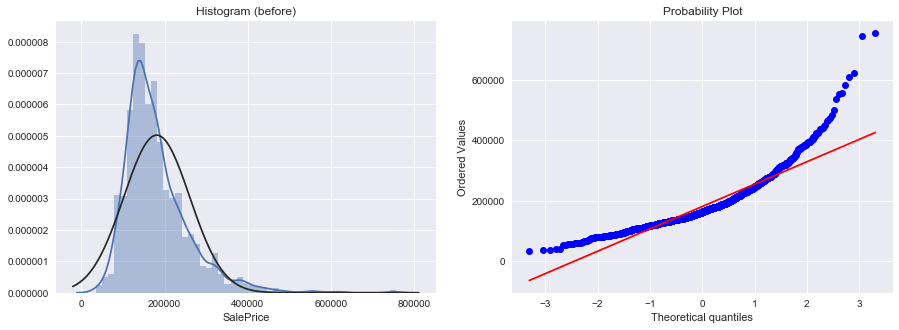

In [267]:
# Histogram and normal probability plot
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train['SalePrice'], fit=norm).set_title("Histogram (before)");
plt.subplot(1, 2, 2)   
stats.probplot(train['SalePrice'], plot=plt);

In [268]:
# Skewness and Kurtosis
print("Skewness: ", round(train['SalePrice'].skew(), 2))
print("Kurtosis: ", round(train['SalePrice'].kurt(), 2))

Skewness:  1.88
Kurtosis:  6.54


We see that the target variable *SalePrice* has a right-skewed distribution. Log transformation appears to reduce the skewness. A normally distributed target variable helps in better modeling the relationship between target and independent variables.

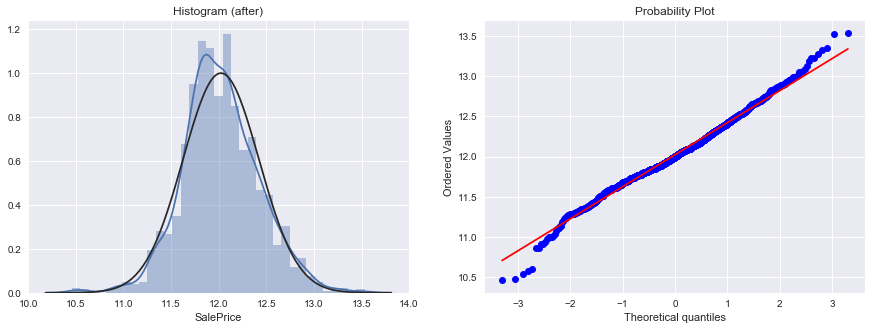

In [269]:
# Applying log transformation
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(np.log(train['SalePrice']), fit=norm).set_title("Histogram (after)");
plt.subplot(1, 2, 2)   
stats.probplot(np.log(train['SalePrice']), plot=plt);

As we see above log transformation of the target variable helps reduce skewed distribution and the new distribution looks closer to normal. 

Then, we start to analyze a few explanatory variables marked with high expected relevance from feature summary.

<a id='grlivarea'></a>
### GrLivArea

*GrLivArea*, above grade living area size, is certainly the most relevant numeric variable. There is a huge gap between 75 percentile and maximum value. This indicates that there could be some outliers that we may consider dropping.

In [270]:
# Descriptive statistics
round(train['GrLivArea'].describe(), 2)

count    1460.00
mean     1515.46
std       525.48
min       334.00
25%      1129.50
50%      1464.00
75%      1776.75
max      5642.00
Name: GrLivArea, dtype: float64

Next we look at the histogram to understand the distribution. It has a long tail with slight right skew. Then, based on the probabilty plot, there are a few outliers seen when *GrLivArea* is greater than 4,000, which are candidates for dropping.

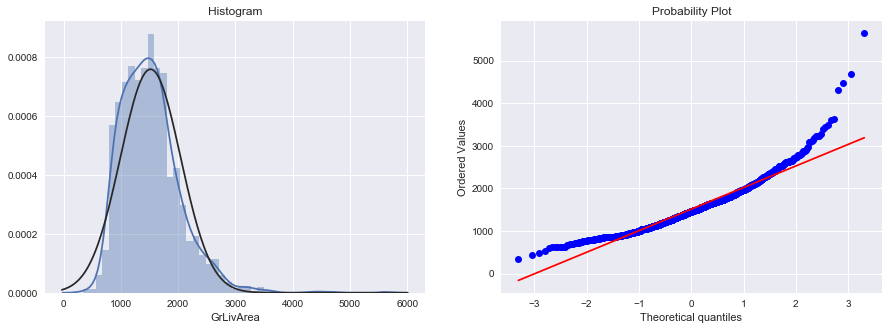

In [271]:
# Histogram and normal probability plot
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train['GrLivArea'], fit=norm).set_title("Histogram");
plt.subplot(1, 2, 2)   
stats.probplot(train['GrLivArea'], plot=plt);

Looks like log transformation is needed to reduce the skewness and improve normal distribution.

<a id='lotarea'></a>
### LotArea

*LotArea*, lot size, is the next most relevant numeric variable. There is a huge gap between 75 percentile and maximum value. This indicates that there could be some outliers that we may consider dropping.

In [272]:
# Descriptive statistics
round(train['LotArea'].describe(), 2)

count      1460.00
mean      10516.83
std        9981.26
min        1300.00
25%        7553.50
50%        9478.50
75%       11601.50
max      215245.00
Name: LotArea, dtype: float64

Next we look at the histogram to understand the distribution. It has a long tail with slight right skew. Then, based on the probabilty plot, there are a few outliers seen when *LotArea* is greater than 75,000, which are candidates for dropping.

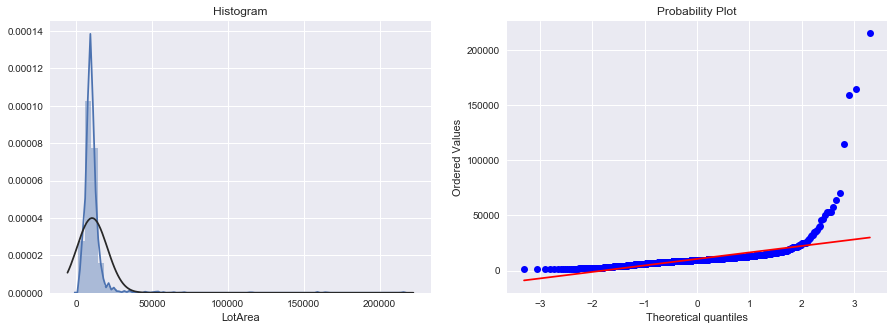

In [273]:
# Histogram and normal probability plot
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train['LotArea'], fit=norm).set_title("Histogram");
plt.subplot(1, 2, 2)   
stats.probplot(train['LotArea'], plot=plt);

The histogram demonstrates normal distribution but has a long tail.

<a id='poolarea'></a>
### PoolArea

*PoolArea* is an interesting numeric variable since majority of the properties don't have a pool and the area should be 0.

In [274]:
# Descriptive statistics
round(train['PoolArea'].describe(), 2)

count    1460.00
mean        2.76
std        40.18
min         0.00
25%         0.00
50%         0.00
75%         0.00
max       738.00
Name: PoolArea, dtype: float64

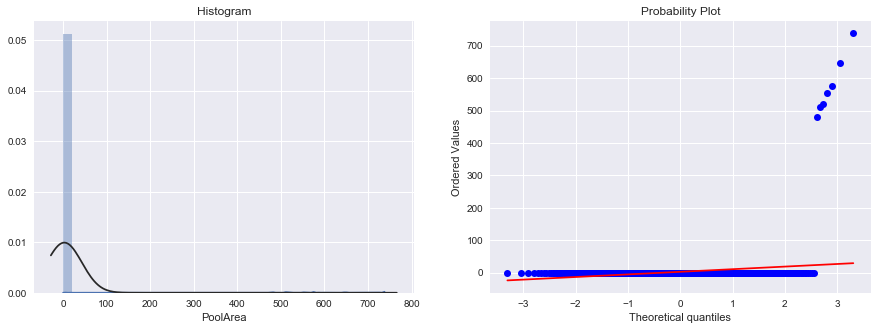

In [275]:
# Histogram and normal probability plot
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.distplot(train['PoolArea'], fit=norm).set_title("Histogram");
plt.subplot(1, 2, 2)   
stats.probplot(train['PoolArea'], plot=plt);

Based on the probability plot, only a handful of properties have swimming pools but majority are without one.

<a id='overallqual'></a>
### OverallQual

*OverallQual* is an example of most relevant discrete numeric variable.

In [276]:
# Descriptive statistics
round(train['OverallQual'].describe(), 2)

count    1460.00
mean        6.10
std         1.38
min         1.00
25%         5.00
50%         6.00
75%         7.00
max        10.00
Name: OverallQual, dtype: float64

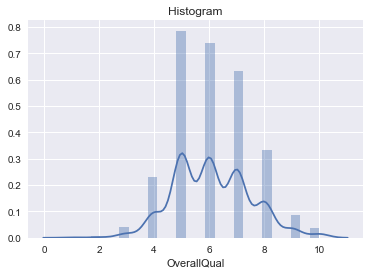

In [277]:
# Histogram
sns.distplot(train['OverallQual']).set_title("Histogram");

As expected, the discrete nature of *OverallQual* feature shows multi-model histogram with a close to normal distribution.

<a id='yearbuilt'></a>
### YearBuilt

*YearBuilt* is one of the most relevant categorical variables.

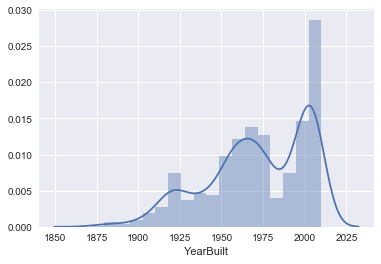

In [278]:
# Histogram
sns.distplot(train['YearBuilt']);

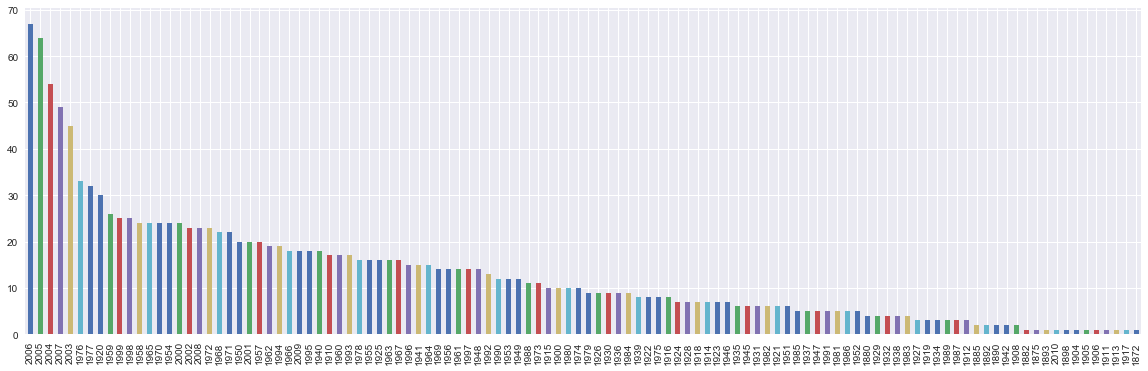

In [279]:
# Histogram sorted in descending order
train['YearBuilt'].value_counts().plot(kind='bar', figsize=(20, 6));

The histogram with years in chronological order doesn't display any observable relationship. However, after sorted the number of houses in descending order, the histogram appears to follow a power curve.

Now, we will look at a few least relevant variables and see why they definitely need to be dropped.

<a id='street_and_miscfeature'></a>
### Street and MiscFeature

- *Street* doesn't give any meaningful information since almost all values are "Pave".  
- With 99.6% of properties have identical *Pave* type, *Street* is a candidate to be dropped.  
- Less than 4% of properties come with this *MiscFeature*, and it is a candidate to be dropped.  

In [21]:
# Descriptive statistics
train['Street'].describe()

count     1460
unique       2
top       Pave
freq      1454
Name: Street, dtype: object

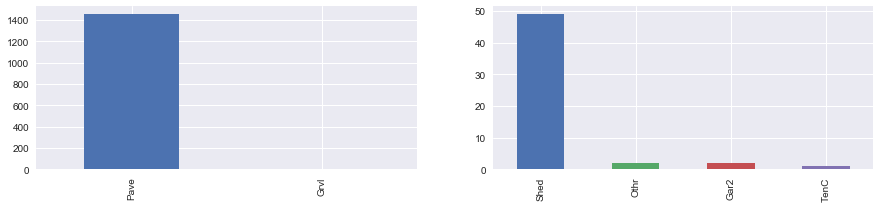

In [282]:
# Sorted in descending order
plt.subplots(figsize=(15, 3))
plt.subplot(1, 2, 1)  
train['Street'].value_counts().plot(kind='bar');

plt.subplot(1, 2, 2)
# Sorted in descending order
train['MiscFeature'].value_counts().plot(kind='bar'); 

<a id='miscval'></a>
### MiscVal

*MiscVal* doesn't give any meaningful information since most of properties come with this value and almost all values are 0.

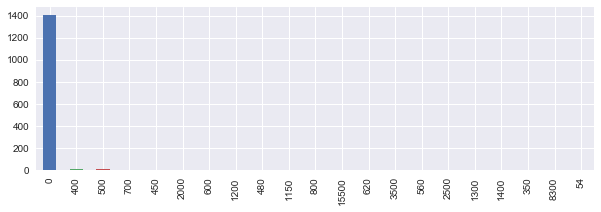

In [285]:
# Sorted in descending order
train['MiscVal'].value_counts().plot(kind='bar', figsize=(10, 3));

More than 95% of properties have *MiscVal* with $0, and it is a candidate to be dropped.

<a id='yrsold and MoSold'></a>
### YrSold and MoSold


*YrSold* appears to be discrete numeric variable and it is a candiate to be converted to categorical.
*MoSold* appears to be discrete numeric variable and it is a candiate to be converted to categorical.

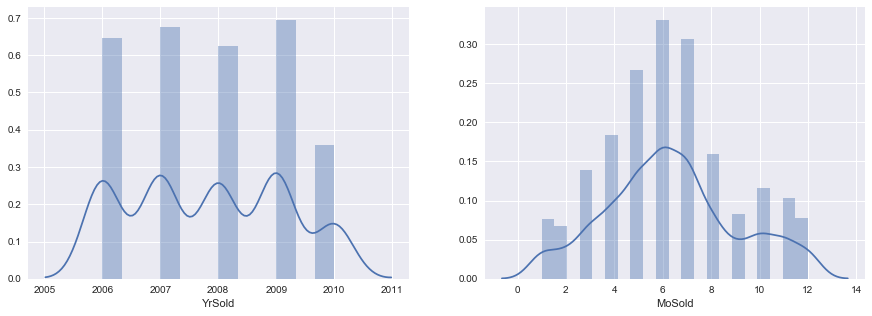

In [286]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2,1 ) 
# Histogram
sns.distplot(train['YrSold']);
plt.subplot(1, 2, 2) 
 # Histogram
sns.distplot(train['MoSold']);

<a id='bivariate_analysis'></a>
## Bivariate Analysis

In this section, we look at the relationship between target variable (*SalePrice*) and some other relevant features.  

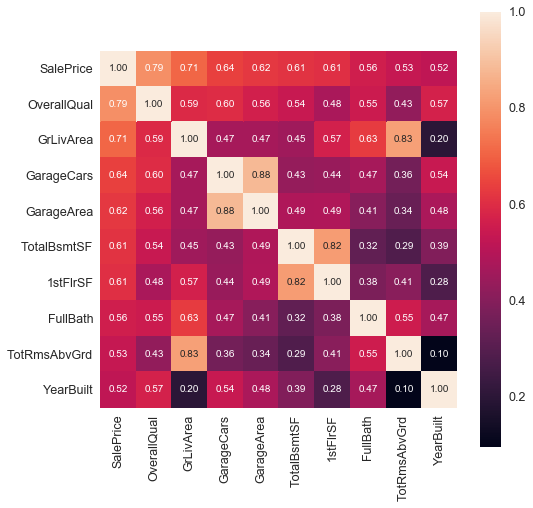

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
Name: SalePrice, dtype: float64 

----------------------
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [287]:
# Correlation matrix showing evidence of multicollearity
# Remove Id column which is totally irrelevant
train_ = train.drop(['Id'], axis=1, errors='raise')
corrmat = train_.corr()

# Saleprice correlation matrix
k = 10 # number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_[cols].values.T)
sns.set(font_scale=1.25)
plt.figure(figsize=(8, 8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f',
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Let us print top correlated features (both positively and negatively) with SalePrice
corr_matrix = train_.corr()
print (corr_matrix['SalePrice'].sort_values(ascending=False)[:10], '\n') # top 10 values
print ('----------------------')
print (corr_matrix['SalePrice'].sort_values(ascending=False)[-10:]) # bottom 10 values

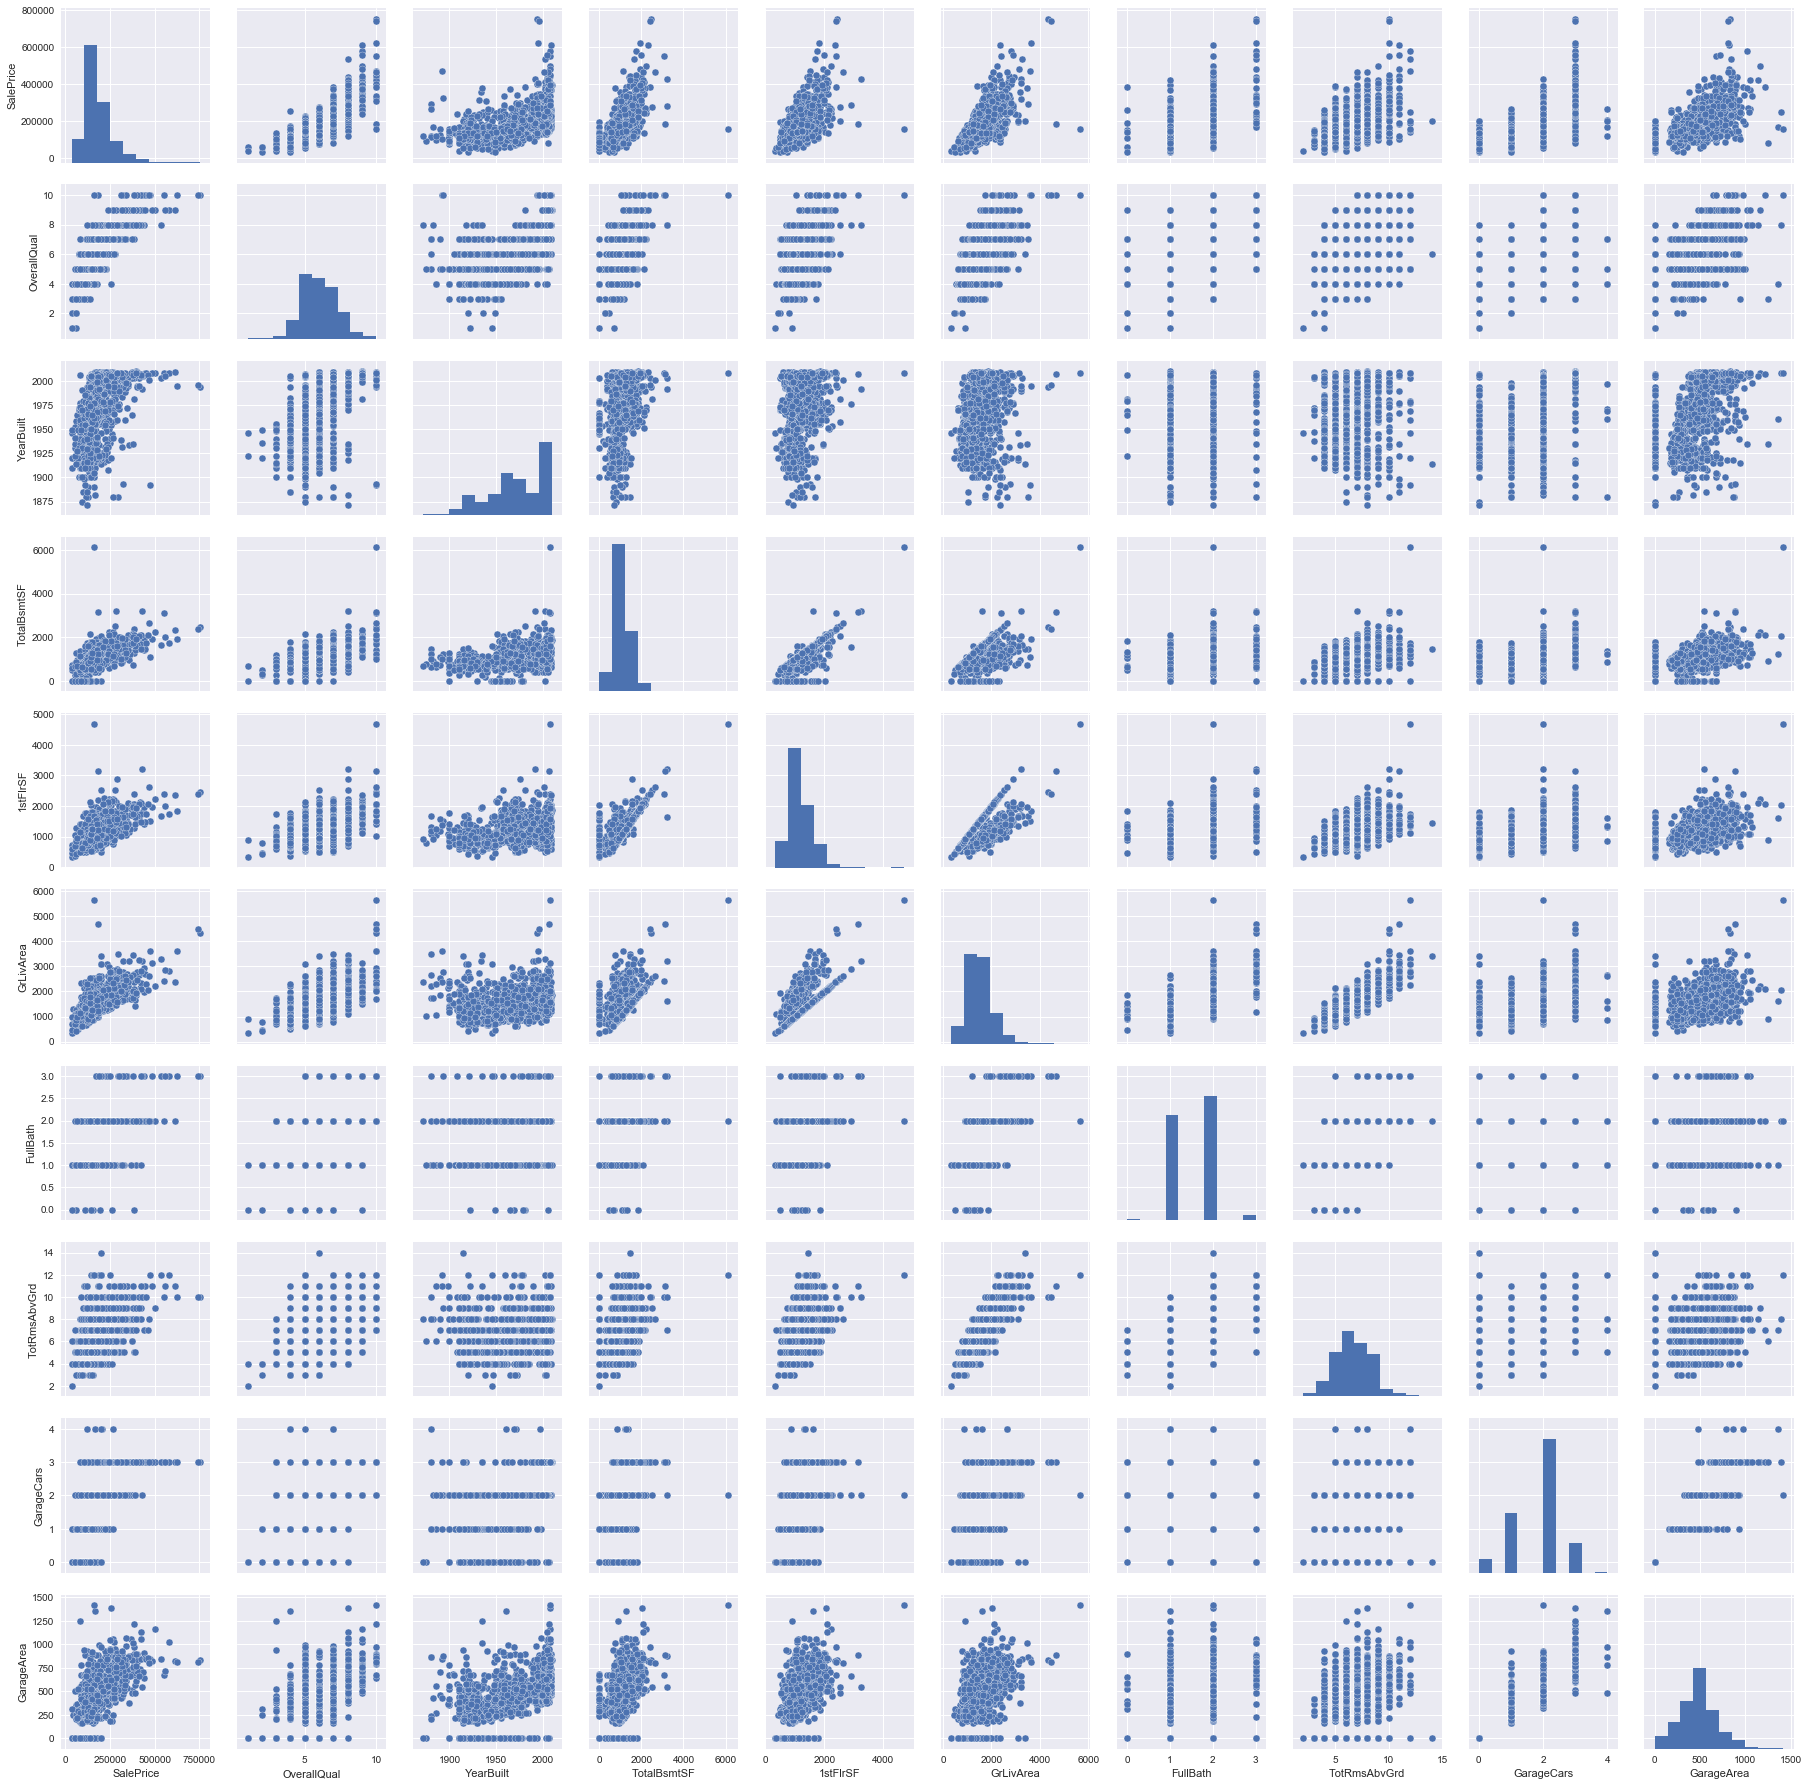

In [288]:
# Scatterplot
sns.set()
cols = ['SalePrice','OverallQual','YearBuilt','TotalBsmtSF','1stFlrSF',
        'GrLivArea','FullBath', 'TotRmsAbvGrd', 'GarageCars','GarageArea']
sns.pairplot(train_[cols], size=2.5)
plt.show();

**Observations**:  
- From the correlation matrix (lighter color -> better correlation), some of the highly correlated features appear to be *OverallQual*, *YearBuilt*, *YearRemodAdd*, *TotalBsmtSF*, *1stFlrSF*, *GrLivArea*, *FullBath*, *TotRmsAbvGrd*, *GarageCars*, and *GarageArea*.  
- Here we see that the *OverallQual* feature is 79% correlated with the target variable. *OverallQual* feature Rates the overall material and finish of the house. This seems to be the parameter that affects the sale price positively. In addition, *GrLivArea* is 70% correlated with the target variable. *GrLivArea* refers to the living area (in sq ft.) above ground.  
- Furthermore, based on the correlation matrix, multicollinearity is seen on a few pair of variables. For example, *GarageArea* and *GarageCars*; *TotRmsAbvGrd* and *GrLivArea*; *TotalBsmtSF* and *1stFlrSF*. *GarageCars* and *TotRmsAbvGrd* are candiates to be dropped since categorical variables will be weaker against the numeric variables in the modeling. *TotalBsmtSF* is candidate to be dropped since there are more explicit variables to describe basements such as *BsmtFinSF1*, *BsmtFinSF2*, and *BsmtUnfSF*.
- From the scatterplot of *SalePrice* vs the 9 other variables from the correlation matrix, look like all demonstrate linear relationship with sale price.

<a id='saleprice_grlivarea'></a>
### SalePrice - GrLivArea Relationship

Since *GrLivArea* is a numeric variable, we look at the scatterplot.

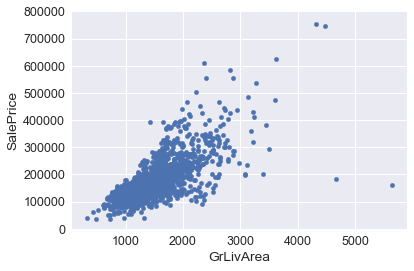

In [26]:
# Scatterplot of GrLivArea/SalePrice
data = pd.concat([train['SalePrice'], train_['GrLivArea']], axis=1)
data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000));

*GrLivArea* and *SalePrice* seem to have linear relationship of larger the area, higher the price. However, there are a few observable outliers, though, on the higher extremes of areas.

<a id='saleprice_overallqual'></a>
### SalePrice - OverallQual Relationship

Since *OverallQual* is a discrete variable, we look at the boxplot.

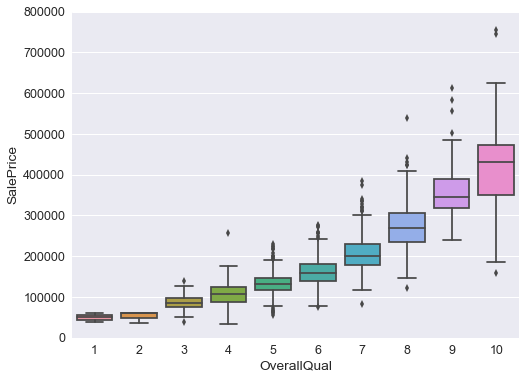

In [27]:
# Boxplot of OverallQual/SalePrice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train_[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

The boxplot shows strong relationship between overall quality of the house and its sale price.

<a id='saleprice_yearbuilt'></a>
### SalePrice - YearBuilt Relationship

Except some historical houses showing higher than usual sale price, boxplot also shows the general trend of higher price for newer house.

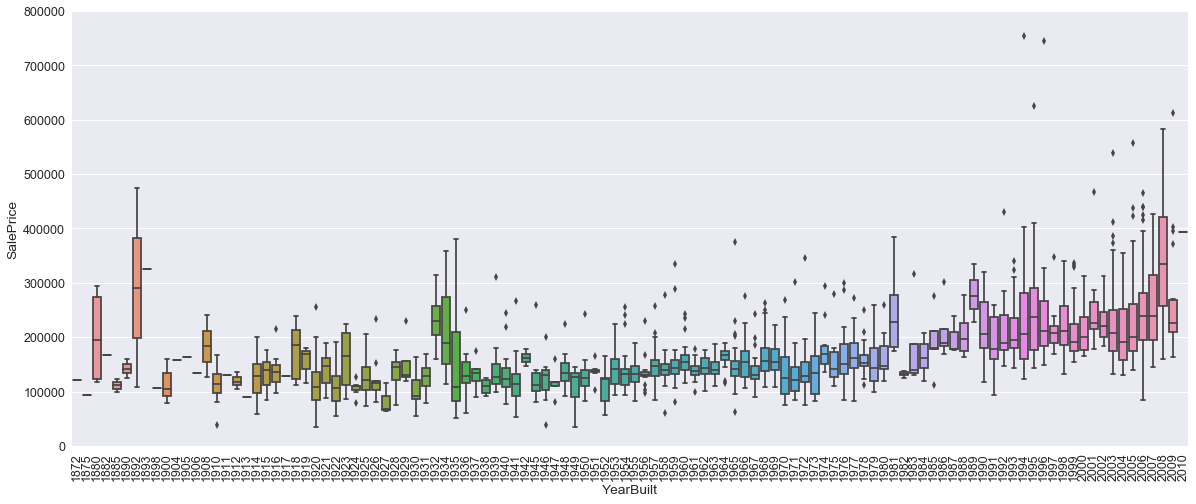

In [28]:
# Boxplot of YearBuilt/SalePrice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train_[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

<a id='saleprice_garagecars'></a>
### SalePrice - GarageCars Relationship

The boxplot shows that there is linear relationship between size of garage and price when garage size is between 0 and 3. House with 4-car garage, though, doesn't appears to positively influence sale price.

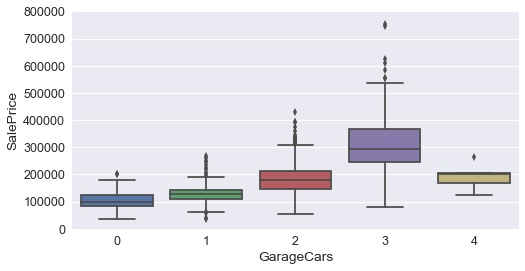

In [29]:
# Boxplot of GarageCars/SalePrice
data = pd.concat([train['SalePrice'], train_['GarageCars']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='GarageCars', y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

<a id='saleprice_bsmtqual'></a>
### SalePrice - BsmtQual Relationship

Since *BsmtQual* is a discrete variable, we look at the boxplot.

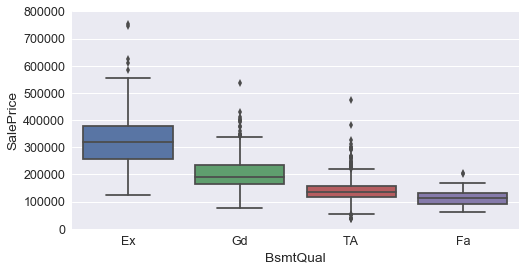

In [30]:
# Boxplot of BsmtQual/SalePrice
data = pd.concat([train['SalePrice'], train_['BsmtQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtQual', y="SalePrice", data=data, order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000);

It shows a linear relationship between sale price and different tier of basement quality.

<a id='saleprice_bsmtcond'></a>
### SalePrice - BsmtCond Relationship

Since *BsmtCond* is a discrete variable, we look at the boxplot.

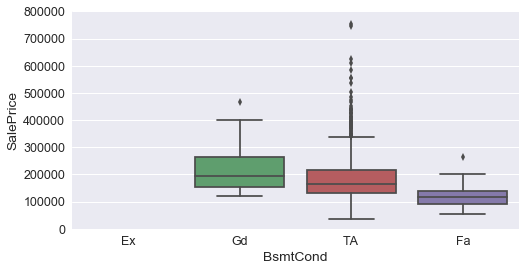

In [31]:
# Boxplot of BsmtCond/SalePrice
data = pd.concat([train['SalePrice'], train_['BsmtCond']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtCond', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000);

It shows a linear relationship between sale price and different tier of basement condition.

<a id='saleprice_bsmtexposure'></a>
### SalePrice - BsmtExposure Relationship

Since *BsmtExposure* is a discrete variable, we look at the boxplot.

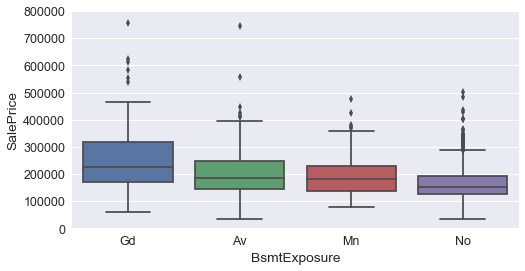

In [32]:
# Boxplot of BsmtExposure/SalePrice
data = pd.concat([train['SalePrice'], train_['BsmtExposure']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='BsmtExposure', y="SalePrice", data=data,
                  order=["Gd", "Av", "Mn", "No"])
fig.axis(ymin=0, ymax=800000);

It shows a linear relationship between sale price and different tier of basement exposure.

<a id='saleprice_kitchenqual'></a>
### SalePrice - KitchenQual Relationship

Since *KitchenQual* is a discrete variable, we look at the boxplot.

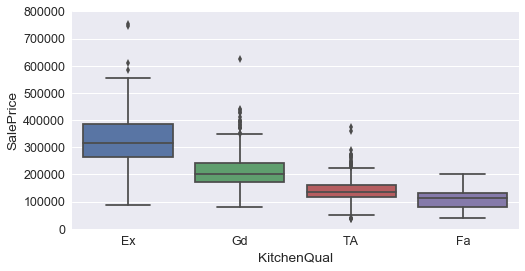

In [33]:
# Boxplot of KitchenQual/SalePrice
data = pd.concat([train['SalePrice'], train_['KitchenQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='KitchenQual', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000);

It shows a linear relationship between sale price and different tier of kitchen quality.

<a id='saleprice_exterqual'></a>
### SalePrice - ExterQual Relationship

Since *ExterQual* is a discrete variable, we look at the boxplot.

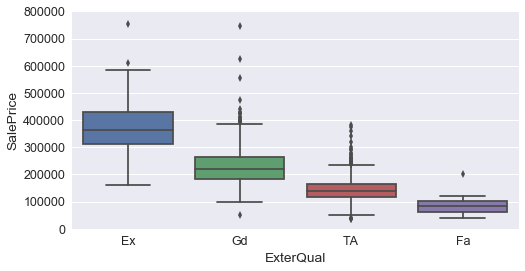

In [34]:
# Boxplot of ExterQual/SalePrice
data = pd.concat([train['SalePrice'], train_['ExterQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x='ExterQual', y="SalePrice", data=data,
                  order=["Ex", "Gd", "TA", "Fa"])
fig.axis(ymin=0, ymax=800000);

It shows a linear relationship between sale price and different tier of exterior quality.

<a id='saleprice_neighborhood'></a>
### SalePrice - Neighborhood Relationship

Since *Neighborhood* is a categorical variable, we look at the boxplot. The neighborhoods on x-axis are also sorted so then the neighborhood with from least to most expensive sale price can be identified. Further clustering analysis could be performed to see if there is any relationship between defined neighborhood cluster and sale price.

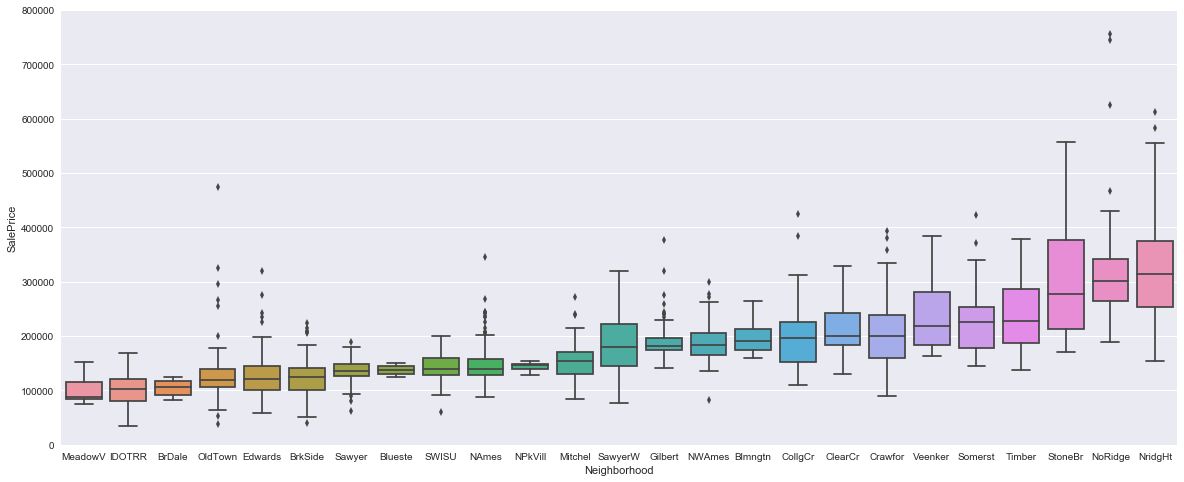

In [299]:
# Boxplot of Neighborhood/SalePrice
data = pd.concat([train['SalePrice'], train_['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
rank = train['SalePrice'].groupby(train['Neighborhood']).median().sort_values(ascending=False)[::-1].index
fig = sns.boxplot(x='Neighborhood', y="SalePrice", data=data, order=rank)
fig.axis(ymin=0, ymax=800000);

<a id='feature_engineering'></a>
# 5. Feature Engineering

Following hyperlinks direct to relevant subsections:
- [Drop Outlier Rows](#drop_outlier_row)
- [Experimental Data Setup for Clustering Analysis](#experimental_data_setup) 
    - [Intepretation of Experiment on Clustering](#interpretation_of_experiment)
- [Combine Train and Test Data](#combining_data)
- [Remove Non-significant Columns](#remove_bad_columns)
- [Missing Data Analysis](#missing_data_analysis)
- [Missing Data Handling](#missing_data_handling)
- [Missing Values Handling](#impute_NaN_values)
- [Adding New Columns (Features)](#add_new_cols)
- [Data Preparation](#data_preparation)
    - [Log Transformations](#log_transformations)
    - [Manually Encoding Ordinal Features](#ordinal_encoding)
    - [Data Binning](#data_binning)
    - [Cleanup For Binning Applied Columns](#binning_cleanup)
    - [Categorical Features: Conversion to Dummy/Indicator Variables](#categorical_encoding)
- [Split Back into Train and Test](#split_back)

<a id='drop_outlier_row'></a>
## Drop Outlier Rows

From univariate analysis we saw that a couple of items with *GrLivArea* > 4,000 are outliers and may not help generalizing the model.

In [36]:
train.drop(train[(train['GrLivArea'] > 4000)].index, inplace=True)

<a id='experimental_data_setup'></a>
## Experimental Data Setup for Clustering Analysis

Before feature engineering, we will check whether some columns can be used for clustering as an experiment. First of all, we take a look at the *Neighborhood* variable. Let's experiment with PCA to see if it's useful for predicting the label. We'll reduce the dimensions down to two and scatterplot them, coloring the points with the value of *SalePrice*.  

Please note that the clustering experimental data setup will not have an impact on the following model analysis.

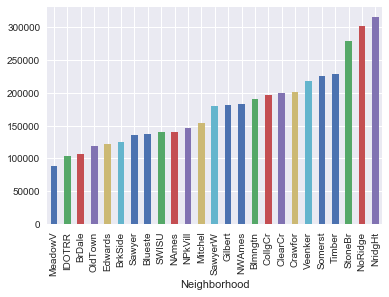

In [245]:
# Grouping Neighborhood variable based on this plot
train['SalePrice'].groupby(train['Neighborhood']).median().sort_values().plot(kind='bar');

In [252]:
# Extract and keep the SalePrice (target) column
Y_train_neigh = train['SalePrice']
X_train_neigh = train['Neighborhood']

In [253]:
# Create new data
train_new = train[train['SalePrice'].notnull()]

In [254]:
# The graph above gives us a good hint on how to combine levels of the Neighborhood
# variable into fewer levels. We can combine bars of equal height in one category. 
# To do this, we create a dictionary and map it with variable values. 

neighborhood_map = {"MeadowV" : 0, "IDOTRR" : 1, "BrDale" : 1, "OldTown" : 1, "Edwards" : 1, "BrkSide" : 1, "Sawyer" : 1, "Blueste" : 1, "SWISU" : 2, "NAmes" : 2, "NPkVill" : 2, "Mitchel" : 2, "SawyerW" : 2, "Gilbert" : 2, "NWAmes" : 2, "Blmngtn" : 2, "CollgCr" : 2, "ClearCr" : 3, "Crawfor" : 3, "Veenker" : 3, "Somerst" : 3, "Timber" : 3, "StoneBr" : 4, "NoRidge" : 4, "NridgHt" : 4}

train_new['NeighborhoodBin'] = train_new['Neighborhood'].map(neighborhood_map)
train_new.loc[train_new.Neighborhood == 'NridgHt', "Neighborhood_Good"] = 1
train_new.loc[train_new.Neighborhood == 'Crawfor', "Neighborhood_Good"] = 1
train_new.loc[train_new.Neighborhood == 'StoneBr', "Neighborhood_Good"] = 1
train_new.loc[train_new.Neighborhood == 'Somerst', "Neighborhood_Good"] = 1
train_new.loc[train_new.Neighborhood == 'NoRidge', "Neighborhood_Good"] = 1
train_new["Neighborhood_Good"].fillna(0, inplace=True)

In [255]:
cols =['NeighborhoodBin','Neighborhood_Good']
train_new = train_new[cols]
test_new = train['SalePrice']

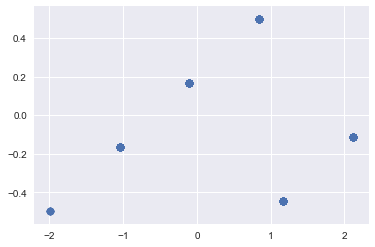

In [257]:
pc_2= PCA()
x_pc = pc_2.fit_transform(train_new)
plt.scatter(x_pc[:,0],x_pc[:,1], label='True Position');

[2 1 2 ... 1 2 0]
(4, 2)
[[9.59232614e-01 1.11022302e-16]
 [3.00000000e+00 6.40186916e-01]
 [2.00000000e+00 2.22044605e-15]
 [4.00000000e+00 1.00000000e+00]]


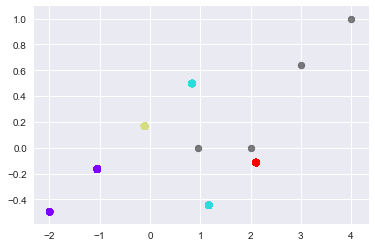

In [259]:
km = KMeans(n_clusters=4, init='k-means++')
clstrs2 = km.fit(train_new)
y_kmeans = km.predict(train_new)
print(km.labels_)
print(clstrs2.cluster_centers_.shape)
print(clstrs2.cluster_centers_)
plt.scatter(x_pc[:, 0], x_pc[:, 1], c=km.labels_, cmap='rainbow')

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], color='black', alpha=0.5);

<a id='interpretation_of_experiment'></a>
### Intepretation of Experiment on Clustering

Before analyzing various models , we used clustering to see whether some grouped columns based on the specific characteristic may lead to different projection. For neighborhood, we assumed that higher sales price may be based on better school districts which is Ames High School ranked 3 in Iowa  (https://www.usnews.com/education/best-high-schools/iowa/districts/ames-comm-school-district/ames-high-school-7498).

However, neighborhoods which are close to the high schools above are Somerset and Bloomington Height. However, they are not top ones when compared with the sale price in the analysis. Hence, clustering through school zone for neighborhood might not have any big impact.

<a id='combining_data'></a>
## Combine Train and Test Data

We will combine train and test data frames so that all feature engineering changes are applied to both together.

In [44]:
# Extract and keep the SalePrice (target) column
Y_train_all = train['SalePrice']
# Drop SalePrice so that is has same cardinality as test dataframe
train.drop('SalePrice', axis=1, inplace=True)

# Preseve test dataset IDs. We will need them for final prediction/submission
test_id = test.iloc[:,0]

# Combine test and train
combined_df = pd.concat([train, test]).reset_index()
combined_df.shape

(2915, 81)

<a id='remove_bad_columns'></a>
## Remove Non-significant Columns

From the univariate analysis, we also found that these columns does not help explain the variations in *SalePrice*
removing these as well.

In [45]:
# ID is not useful
combined_df.drop('Id', axis=1, inplace=True)

# Almost all rows have same value for Utilities, making this variable not useful
combined_df.drop('Utilities', axis=1, inplace=True)
combined_df.drop('Street', axis=1, inplace=True)
combined_df.drop('MiscFeature', axis=1, inplace=True)
combined_df.drop('MiscVal', axis=1, inplace=True)

From the bivariate analysis, we found some dditional variables could be dropped to avoid multicollinearity.

In [46]:
combined_df.drop(['GarageCars','TotRmsAbvGrd','TotalBsmtSF'],axis=1,
                 inplace=True, errors='ignore')

<a id='missing_data_analysis'></a>
## Missing Data Analysis

In this section, we will analyze missing values in the data set and approach to tackle these.

In [47]:
# Investigate about missing data
# Analyze top 20 columns having missing data
total = combined_df.isnull().sum().sort_values(ascending=False)
percent = (combined_df.isnull().sum()/combined_df.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat(
    [total, percent], axis=1,
    keys=["Total Number of Missing Data","Missing Data Percentage"])
missing_data.head(20)

,Total Number of Missing Data,Missing Data Percentage
PoolQC,2907,99.725557
Alley,2717,93.207547
Fence,2345,80.445969
FireplaceQu,1420,48.713551
LotFrontage,486,16.672384
GarageFinish,159,5.454545
GarageYrBlt,159,5.454545
GarageCond,159,5.454545
GarageQual,159,5.454545
GarageType,157,5.385935


<a id='missing_data_handling'></a>
## Missing Data Handling

1. We can safely drop columns with ~80% or more missing data

In [48]:
columns_will_be_removed = ['PoolQC','MiscFeature','Alley','Fence']

combined_df.drop(columns_will_be_removed, axis=1, inplace=True, errors='ignore')

# Double check whether above columns are removed
total = combined_df.isnull().sum().sort_values(ascending=False)
percent = (combined_df.isnull().sum() / combined_df.isnull().count() * 100).sort_values(ascending=False)

def assert_column_drop(data, col_names):
    for col_name in col_names:
        assert col_name not in data, "%s should not exist" % col_name
        
assert_column_drop(combined_df, columns_will_be_removed)

In [49]:
print("Shape of data set after removing columns with 80% missing data: {}".format(combined_df.shape))

Shape of data set after removing columns with 80% missing data: (2915, 70)


<a id='impute_NaN_values'></a>
## Missing Values Handling

For imputing missing values, we looked at each column and its description (in the given description text file) independently and chose imputed values individually. For some columns, default value is given in the description file.
1. From documentation: data_description.txt, the following column's default value (when NaN) is **None**.

In [50]:
default_none_columns = ['FireplaceQu','GarageType','GarageFinish','GarageQual',
                        'GarageCond','BsmtQual','BsmtCond','BsmtExposure',
                        'BsmtFinType1','BsmtFinType2','MasVnrType']

for none_column in default_none_columns:
    combined_df[none_column].fillna('None', inplace = True)

2. From documentation: data_description.txt, the following column's default value (when NaN) is **0**. 

In [51]:
default_zero_columns = ['GarageYrBlt','GarageArea','BsmtFinSF1','BsmtFinSF2',
                        'BsmtUnfSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']

for zero_column in default_zero_columns:
    combined_df[zero_column].fillna(0, inplace = True)

3. Using background knowledge, we set the missing value to the **mode** for some variables.

In [52]:
combined_df['Electrical'].fillna(combined_df['Electrical'].mode()[0], inplace=True)

4. *LotFrontage*: We will replace missing values with **mean** of the available data points for this column.

In [53]:
combined_df['LotFrontage'].fillna(combined_df['LotFrontage'].mean(), inplace=True)

5. We observed that values of some rows in the **test** data set has missing values (these columns do not have missing values in the train dataset). Missing values for these categorical (ordinal) type features: we will impute them with **mode** of the available values.

In [54]:
combined_df['MSZoning'].fillna(combined_df['MSZoning'].mode()[0], inplace=True)
combined_df['Functional'].fillna(combined_df['Functional'].mode()[0], inplace=True)
combined_df['SaleType'].fillna(combined_df['SaleType'].mode()[0], inplace=True)
combined_df['KitchenQual'].fillna(combined_df['KitchenQual'].mode()[0], inplace=True)
combined_df['Exterior1st'].fillna(combined_df['Exterior1st'].mode()[0], inplace=True)
combined_df['Exterior2nd'].fillna(combined_df['Exterior2nd'].mode()[0], inplace=True)

Verify that there are no more missing values in the data set:

In [55]:
assert combined_df.isnull().sum().sum() == 0

<a id='add_new_cols'></a>
## Adding New Columns (Features)

Informed by our background understanding of the domain, we are adding the following two features (as a combination of other existing features).

In [56]:
combined_df['TotalAreaSF'] = combined_df['GrLivArea'] + combined_df['GarageArea'] + combined_df['EnclosedPorch'] + combined_df['ScreenPorch']
combined_df['LivingAreaSF'] = combined_df['1stFlrSF'] + combined_df['2ndFlrSF']

<a id='data_preparation'></a>
## Data Preparation

In this section, we will prepare data for machine learning modeling. This includes preprocessing, transformation, encoding, and scaling data.

<a id='log_transformations'></a>
### Log Transformations

As we found during univariate analysis, log transformation of the output variable *SalePrice* would help with modeling linear regressions.

In [57]:
Y_train_all = np.log(Y_train_all)

We will also perform log transformation for these numeric features. Note that since the min value of *PoolArea* is 0, we cannot perform log transformation. We will, instead, use *log1p* transformation.

In [58]:
log_features = ['LotArea','PoolArea']

for log_feature in log_features:
    combined_df[log_feature] = np.log1p(combined_df[log_feature])

<a id='ordinal_encoding'></a>
### Manually Encoding Ordinal Features

We manually encode ordered values for ordinal categorical features.

In [59]:
combined_df['BsmtQual'] = combined_df['BsmtQual'].map({"None":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})
combined_df['BsmtCond'] = combined_df['BsmtCond'].map({"None":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5})
combined_df['BsmtExposure'] = combined_df['BsmtExposure'].map({"None":0, "NA":0, "No":1, "Mn":2, "Av":3, "Gd":4})
combined_df['KitchenQual'] = combined_df['KitchenQual'].map({"Fa":1, "TA":2, "Gd":3, "Ex":4})
combined_df['ExterQual'] = combined_df['ExterQual'].map({"Po":0, "Fa":1, "TA":2, "Gd":3, "Ex":4})

<a id='data_binning'></a>
### Data Binning

1. To reduce side impact of filled data with default value, we decided to bin year data into pre-1950, 1950-1974, 1975 -2000, and post-2000, respectively. By this approach, if default value is filled by zero, it will be categorized into pre-1950 instead of recognizing data itself as zero. We can assume that if data is missing, house data may not be recorded properly since it was built or remodeled before 1950.
2. After binning, the target column having continuous integer value will be dropped.
3. As a final step, value will be transformed into discrete value such as 1, 2, 3, or 4. Since recent update on the property can have a positive impact, larger value assigned for the recent years can be justfied.

In [60]:
PERIOD_TO_VALUE = {'0': 0, 'Before1950': 1, '1950to1974': 2, '1975to1999': 3, '2000OrLater': 4}

# Data Binning

# GarageYrBlt -> GarageBlt
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 1950) & (combined_df["GarageYrBlt"].apply(int) >= 0), "GarageBlt"] = 'Before1950'
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 1975) & (combined_df["GarageYrBlt"].apply(int) >= 1950), "GarageBlt"] = '1950to1974'
combined_df.loc[(combined_df["GarageYrBlt"].apply(int) < 2000) & (combined_df["GarageYrBlt"].apply(int) >= 1975), "GarageBlt"] = '1975to1999'
combined_df.loc[combined_df["GarageYrBlt"].apply(int) >= 2000, "GarageBlt"] = '2000OrLater'

# YearRemodAdd -> YrRemodeled
# Assume that there is no remodeling if built year == remodeled year
combined_df.loc[combined_df["YearRemodAdd"] == combined_df["YearBuilt"], "YrRemodeled"] = 0
combined_df.loc[(combined_df["YearRemodAdd"] < 1950) & (combined_df["YearRemodAdd"] != 0), "YrRemodeled"] = 'Before1950'
combined_df.loc[(combined_df["YearRemodAdd"] < 1975) & (combined_df["YearRemodAdd"] >= 1950), "YrRemodeled"] = '1950to1974'
combined_df.loc[(combined_df["YearRemodAdd"] < 2000) & (combined_df["YearRemodAdd"] >= 1975), "YrRemodeled"] = '1975to1999'
combined_df.loc[combined_df["YearRemodAdd"] >= 2000, "YrRemodeled"] = '2000OrLater'

# YearBuilt -> YrBuilt
combined_df.loc[combined_df["YearBuilt"] < 1950, "YrBuilt"] = 'Before1950'
combined_df.loc[(combined_df["YearBuilt"] < 1975) & (combined_df["YearBuilt"] >= 1950), "YrBuilt"] = '1950to1974'
combined_df.loc[(combined_df["YearBuilt"] < 2000) & (combined_df["YearBuilt"] >= 1975), "YrBuilt"] = '1950to1974'
combined_df.loc[combined_df["YearBuilt"] >= 2000, "YrBuilt"] = '2000OrLater'

combined_df['GarageBlt'] = combined_df['GarageBlt'].apply(lambda period: PERIOD_TO_VALUE[period])
combined_df['YrRemodeled'] = combined_df['YrRemodeled'].apply(lambda period: PERIOD_TO_VALUE[period])
combined_df['YrBuilt'] = combined_df['YrBuilt'].apply(lambda period: PERIOD_TO_VALUE[period])

def get_distinct_values(values):
    return ",".join([str(i) for i in (set(values))])

# Check data binning results
print("GarageBlt column values:", get_distinct_values(combined_df["GarageBlt"]))
print("YrRemodeled column values:", get_distinct_values(combined_df["YrRemodeled"]))
print("YrBuilt column values:", get_distinct_values(combined_df["YrBuilt"]))

GarageBlt column values: 1,2,3,4
YrRemodeled column values: 2,3,4
YrBuilt column values: 1,2,4


<a id='binning_cleanup'></a>
### Cleanup For Binning Applied Columns

We drop columns after data binning. Continuous data is no longer meaningful.

In [61]:
combined_df.drop(['GarageYrBlt', 'YearRemodAdd', 'YearBuilt'], axis=1, inplace=True, errors='ignore')

<a id='categorical_encoding'></a>
### Categorical Features: Conversion to Dummy/Indicator Variables

In [62]:
combined_df.shape
category_columns = [f for f in combined_df.columns if combined_df.dtypes[f] == 'object']
category_columns.sort()
for col in category_columns:
    if (train[col].nunique() <= 10):
        print ('{}: {}, {}'.format(col, combined_df[col].nunique(), combined_df[col].unique()))

BldgType: 5, ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
BsmtFinType1: 7, ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
BsmtFinType2: 7, ['Unf' 'BLQ' 'None' 'ALQ' 'Rec' 'LwQ' 'GLQ']
CentralAir: 2, ['Y' 'N']
Condition1: 9, ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2: 8, ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosA' 'PosN' 'RRAn' 'RRAe']
Electrical: 5, ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix']
ExterCond: 5, ['TA' 'Gd' 'Fa' 'Po' 'Ex']
FireplaceQu: 6, ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Foundation: 6, ['PConc' 'CBlock' 'BrkTil' 'Wood' 'Slab' 'Stone']
Functional: 7, ['Typ' 'Min1' 'Maj1' 'Min2' 'Mod' 'Maj2' 'Sev']
GarageCond: 6, ['TA' 'Fa' 'None' 'Gd' 'Po' 'Ex']
GarageFinish: 4, ['RFn' 'Unf' 'Fin' 'None']
GarageQual: 6, ['TA' 'Fa' 'Gd' 'None' 'Ex' 'Po']
GarageType: 7, ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' 'None' 'Basment' '2Types']
Heating: 6, ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
HeatingQC: 5, ['Ex' 'Gd' 'TA' 'Fa' 'Po']
HouseStyle: 8, ['2Story' '1Story' '1.5Fi

In [63]:
combined_df = pd.get_dummies(combined_df, drop_first=True)
combined_df['MSSubClass'] = combined_df['MSSubClass'].astype(str)
combined_df = pd.get_dummies(combined_df, columns = ["MoSold",'YrSold','MSSubClass'], drop_first=True)
combined_df.shape

(2915, 256)

<a id='split_back'></a>
## Split Back into Train and Test

In [64]:
X_train_all = combined_df[:train.shape[0]]
X_test = combined_df[train.shape[0]:]
X_train_all.shape,X_test.shape

((1456, 256), (1459, 256))

<a id='modeling'></a>
# 6. Modeling

In this section, we'll perform the following:
* Preprocessing data to make it ready for machine learning modeling
* Building and tuning home prices prediction models using cross-validations
* Selecting the best model
 

We plan to start with Linear Regression model because of the predictive nature of the problem. We will also try other supervised learning models such as Random Forest, Gradient Boosting Tree and if they increase accuracy.

We will be working on two broad sets of algorithms:
1. Linear models
2. Non-linear relationships using Random Forests

We begin with (multiple) LinearRegression model (for speed) and if the accuracy is not satisfactory, we try other models such as random forest and gradient-boosting tree. We are ensembling all the models for better overall accuracy. We will split test data into two random sets and use one as "dev" data for measuring the performance during model building process.

### Linear Models
For linear models, we have regular OLS model, and the regularized linear models of Ridge Regression, Least Absolute Shrinkage and Selection Operator (LASSO), and Elastic Net. 

For model tuning, Sklearn's grid search with CV function is used to find the optimal hyper-parameter values.

To assess the predictive performance of regression models, we can compute the mean sum of squared errors and the related summary metric. Furthermore, we also use graphical approach of residual plots to diagnose problems of linear regression models.

We apply regularization to our regression models to reduce the model complexity and avoid overfitting.

### Non-Linear Relationships using Random Forests
Since random forests are less sensitive to outliers in the dataset, we are assuming at this point that it will not require much parameter tuning. The only parameter that will require experimenting might be number of trees. 

Following hyperlinks direct to relevant subsections:
- [Scaling Features](#scaled_feats)
- [Create Cross Validation (Dev) Data Set for Testing Model Performance](#cross_validation)
- [Model Baseline](#model_baseline)
- [Using Grid Search to Tune Hyperparameters](#gridsearch_tuning)
- [Final Model Benchmark](#model_benchmark)
- [Predict Test and Prepare Submission](#predict_test_prep_submission)
    - [Using the best Lasso model](#best_lasso)
    - [Interpreting Coefficients for Our Best Model - Lasso Regularized](#lasso_regularized)
    - [Drivers of Sale Price](#drivers_of_saleprice)
    - [Using the best Gradient Boosting model](#best_gb)
    - [Using the ensemble of models](#ensemble)

<a id='scaled_feats'></a>
## Scaling Features

We will scale all the input features before running models on them to transform them into standard Gaussian distribution. Some machine learning algorithms work better with this transformation (a feature with large scale does not dominate another feature with smaller scale).

In [65]:
scaler = StandardScaler()
scaler.fit(X_train_all)

X_train_all = scaler.transform(X_train_all)
X_train_all = pd.DataFrame(X_train_all, columns = combined_df.columns)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = combined_df.columns)

<a id='cross_validation'></a>
## Create Cross Validation (Dev) Data Set for Testing Model Performance

We will begin with dividing train data into train and dev for model benchmarking and testing.

In [66]:
# Define cutoff to bisect train and cross validation data
cutoff = (len(train) * 80) // 100

X_dev = X_train_all[cutoff:]
Y_dev = Y_train_all[cutoff:]
X_train = X_train_all[:cutoff]
Y_train = Y_train_all[:cutoff]
X_dev.shape,Y_dev.shape

((292, 256), (292,))

In [67]:
def rmse(predictions, targets):
    return '%.4f' % np.sqrt(mean_squared_error(predictions,targets))

In [68]:
res = defaultdict(dict)

'''
Run the given model and store benchmarks for later analysis.
'''
def benchmark(model, name=None):
    if not name:
        name = model.__class__.__name__
    t0 = time.clock()
    model.fit(X_train, Y_train)
    res[name]['train_time'] = time.clock() - t0
    res[name]['train_rmse'] = rmse(Y_train, model.predict(X_train))
    
    t0 = time.clock()
    Y_pred = model.predict(X_dev)
    res[name]['test_time'] = time.clock() - t0
    res[name]['test_rmse'] = rmse(Y_dev, Y_pred)
    return model

<a id="model_baseline"></a>
## Model Baseline

We will run through the selected models for baseline before we tune them.

In [69]:
# Running all models with default values
benchmark(LinearRegression())
benchmark(Lasso(alpha=1.0))
benchmark(Ridge(alpha=1.0))
benchmark(ElasticNet(alpha=1.0))
est = benchmark(GradientBoostingRegressor(learning_rate=0.1, n_estimators=100))
benchmark(RandomForestRegressor(n_estimators=10, max_depth=None))
res_df = pd.DataFrame(data=res).T
res_df[['train_time','test_time','train_rmse','test_rmse']]

,train_time,test_time,train_rmse,test_rmse
ElasticNet,0.0070657,0.000292498,0.3994,0.3820
GradientBoostingRegressor,0.58649,0.000735101,0.0812,0.1245
Lasso,0.0105711,0.000420498,0.3994,0.3820
LinearRegression,0.0180562,0.000301751,0.0892,34483519570.1399
RandomForestRegressor,0.179664,0.000899599,0.0631,0.1487
Ridge,0.00939541,0.000456482,0.0892,0.1218


<a id='gridsearch_tuning'></a>
## Using Grid Search to Tune Hyperparameters

We use grid search on each one of the following models for the purpose of tuning hyperparameters:
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Gradient Boost
- Random Forest

In [70]:
# Ridge regression
ALPHAS = np.array([10, 5, 0.1, 0.01, 0.001, 0.0001, 0])

# Create and fit a ridge regression model, testing each alpha
model = Ridge()
grid = GridSearchCV(estimator=model, cv=10, param_grid=dict(alpha=ALPHAS), scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, Y_train)

# Print best params and score
print('Best parameters:', grid.best_estimator_.alpha)
print('Best score:', -grid.best_score_)

Best parameters: 10.0
Best score: 0.01627691168331022


In [71]:
# Lasso regression
ALPHAS = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05]

# Create and fit a Lasso regression model, testing each alpha
ls = Lasso()
grid_ls = GridSearchCV(estimator=ls, param_grid=dict(alpha=ALPHAS), scoring='neg_mean_squared_error', n_jobs=-1)
grid_ls.fit(X_train, Y_train)

# Print best params and score
print('Best parameters:', grid_ls.best_estimator_.alpha)
print('Best score:', -grid_ls.best_score_)

Best parameters: 0.005
Best score: 0.014326547770994796


In [72]:
# Elastic net regression
param_grid = [{'alpha': np.logspace(0, 1, 10), 'l1_ratio': np.linspace(0, 1, 10)}]

# Create and fit a Elastic net regression model
grid_en = GridSearchCV(estimator=ElasticNet(), param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
grid_en.fit(X_train, Y_train)

# Print best params and score
print('Best parameters: alpha: {}, l1_ratio: {}'.format(grid_en.best_estimator_.alpha,grid_en.best_estimator_.l1_ratio))
print('Best score: {}'.format(-grid_en.best_score_))


Best parameters: alpha: 1.0, l1_ratio: 0.0
Best score: 0.017129364880002728


In [73]:
grid_en.best_estimator_

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [74]:
# Gradient boosting model
param_grid={'n_estimators':[100],
           'learning_rate': [0.01,0.1, 1],
           'max_depth':[4,6,10],
           'min_samples_leaf':[3,5]
           }
gbModel = GridSearchCV(estimator=GradientBoostingRegressor(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
gbModel.fit(X_train, Y_train)
print('Best parameters: n_estimators: {}, learning_rate: {}, max_depth: {}, min_samples_leaf: {}'.format(
    gbModel.best_estimator_.n_estimators,gbModel.best_estimator_.learning_rate, gbModel.best_estimator_.max_depth, gbModel.best_estimator_.min_samples_leaf))

Best parameters: n_estimators: 100, learning_rate: 0.1, max_depth: 4, min_samples_leaf: 3


In [75]:
gbModel.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=4, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=3,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [76]:
# Random Forest model
param_grid={'n_estimators':[50,100],
           'max_depth':[5,10,20],
           }
rfModel = GridSearchCV(estimator=RandomForestRegressor(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
rfModel.fit(X_train, Y_train)
print('Best estimators:', rfModel.best_estimator_.n_estimators)
print('Best max depth:', rfModel.best_estimator_.max_depth)
print('Best score:', rfModel.best_score_)

Best estimators: 100
Best max depth: 20
Best score: -0.020546028308560046


In [77]:
rfModel.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [78]:
grid_ls.best_estimator_.alpha

0.005

<a id="model_benchmark"></a>
## Final Model Benchmark

Then, we use the best parameters from grid search CV to find the best model.

In [79]:
benchmark(LinearRegression())
benchmark(Lasso(alpha=grid_ls.best_estimator_.alpha))
benchmark(Ridge(alpha=grid.best_estimator_.alpha))
benchmark(ElasticNet(alpha=grid_en.best_estimator_.alpha, l1_ratio=grid_en.best_estimator_.l1_ratio))
est = benchmark(GradientBoostingRegressor(max_depth=gbModel.best_estimator_.max_depth, min_samples_leaf=gbModel.best_estimator_.min_samples_leaf, learning_rate=gbModel.best_estimator_.learning_rate, n_estimators=100))
benchmark(RandomForestRegressor(n_estimators=rfModel.best_estimator_.n_estimators, max_depth=rfModel.best_estimator_.max_depth))

res_df = pd.DataFrame(data=res).T

res_df[['train_time', 'test_time', 'train_rmse', 'test_rmse']]

,train_time,test_time,train_rmse,test_rmse
ElasticNet,0.205509,0.000271936,0.1149,0.1213
GradientBoostingRegressor,0.824528,0.000910908,0.0615,0.1244
Lasso,0.0423048,0.000321799,0.1061,0.1143
LinearRegression,0.0161275,0.000710426,0.0892,34483519570.1399
RandomForestRegressor,1.79187,0.00698243,0.0539,0.1376
Ridge,0.00807634,0.000245205,0.0904,0.1213


From above results, we see that Lasso and GradientBoostingRegressor are the models with best results (lowest rmse on dev data). LinearRegression output is too off the chart primarily because of multicollinearity.

<a id='predict_test_prep_submission'></a>
## Predict Test and Prepare Submission

<a id='best_lasso'></a>
### Using the best Lasso model

Using Lasso as our first best model based on the RMSE from Grid Search results above.

In [80]:
final_model = Lasso(alpha=grid_ls.best_estimator_.alpha)
final_model.fit(X_train_all, Y_train_all)
y_test = np.exp(final_model.predict(X_test))
pred_df = pd.DataFrame()
pred_df['Id'] = test_id
pred_df['SalePrice'] = y_test
pred_df.to_csv('w207_mlairev5_Lasso.csv', index=False)
print('result csv generated.')

result csv generated.


<a id='lasso_regularized'></a>
### Interpreting Coefficients for Our Best Model - Lasso Regularized 

For our best model Lasso will be plot top 10 coefficients using the below function

In [81]:
def plot_coefficients(final_model, n = 10):
    cols = X_train_all.columns
    coeffs = final_model.coef_
    zipped = list(zip(cols, coeffs))
    zipped.sort(key=lambda x: x[1], reverse=True)
    postive_10 = pd.DataFrame(zipped).head(n)
    negative_10 = pd.DataFrame(zipped).tail(n)
    return pd.concat([postive_10, negative_10], axis=0).plot.barh(x=0, y=1)

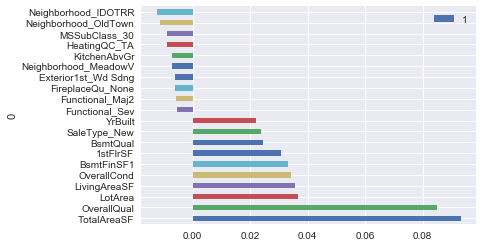

In [82]:
plot_coefficients(final_model)

In [83]:
print("% of Features used in the best model: " + str(100 *(sum(final_model.coef_ > 0) / final_model.coef_.shape[0])))

% of Features used in the best model: 17.96875


<a id='drivers_of_saleprice'></a>
### Drivers of Sale Price 

From the above coefficients plot, we see that the feature that adds the most value to the Sale Price of a home in Ames, Iowa is the 'TotalAreaSF', which is combination of GrLivArea,GarageArea, EnclosedPorch and ScreenPorch areas. Other features that have a strong postive effect on the Sale Price are OverallQual that rates the overall material and finish of the house, Living area in square feet ,LotArea: Lot size in square feet and the rating for overall condition of the house.

On the other hand, we see that the Neighborhood_IDOTRR has most negative impact on the Sale Price. 

<a id='best_gb'></a>
### Using the best Gradient Boosting model

In [84]:
final_gbr = GradientBoostingRegressor(max_depth=gbModel.best_estimator_.max_depth, min_samples_leaf=gbModel.best_estimator_.min_samples_leaf, learning_rate=gbModel.best_estimator_.learning_rate, n_estimators=100)
final_gbr.fit(X_train_all, Y_train_all)
y_test = np.exp(final_gbr.predict(X_test))
pred_df = pd.DataFrame()
pred_df['Id'] = test_id
pred_df['SalePrice'] = y_test
pred_df.to_csv('w207_mlairev3.csv', index=False)
print('result csv generated.')

result csv generated.


Text(0,0.5,'Features')

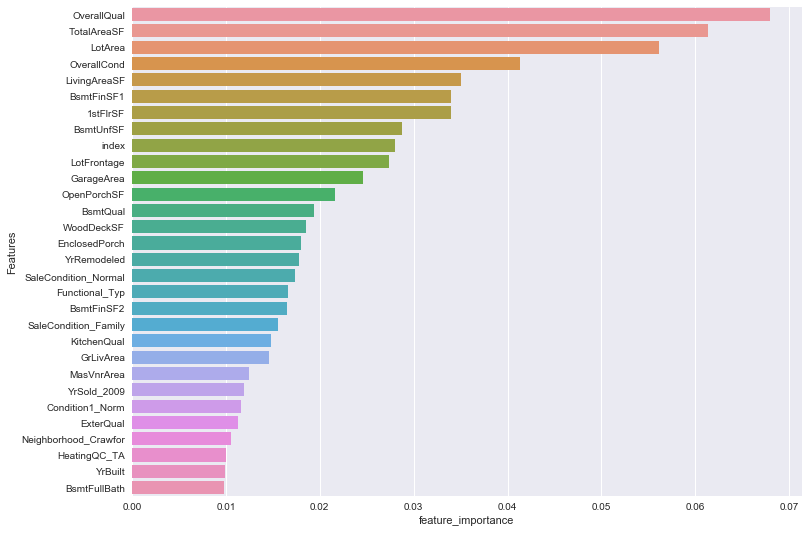

In [85]:
# Analyzing our 2nd best model GradientBoostingRegressor by getting relative importance of each attribute
varImp = pd.DataFrame({'index':X_train_all.columns, 'feature_importance':gbModel.best_estimator_.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])

p = sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax=ax);
p.set_ylabel("Features")

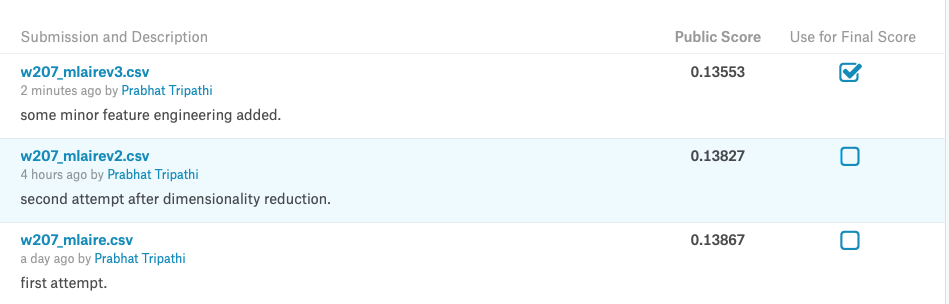

In [86]:
Image(filename='kaggle_submissions_gbr.png', width=800)

<a id='ensemble'></a>
### Using the ensemble of models

We will ensemble (combine) results from all models (except LinearRegression model because that is way off) to prepare an ensemble prediction. The idea behind trying this approach is that some models may be good in explaning a particular type of variability (or signal). Combining these weak models will, hoepefully, help us pick the best of these individual models.

Since the performance of all 5 models are pretty close, we will use simple mean to produce ensemble predictions.

In [87]:
# Ensemble
final_ridge = Ridge(alpha=grid.best_estimator_.alpha)
final_elasticnet = ElasticNet(alpha=grid_en.best_estimator_.alpha, l1_ratio=grid_en.best_estimator_.l1_ratio)
final_randomforest = RandomForestRegressor(n_estimators=rfModel.best_estimator_.n_estimators, max_depth=rfModel.best_estimator_.max_depth)

models = [final_model, final_ridge, final_elasticnet, final_gbr, final_randomforest]
model_names = ['Lasso', 'Ridge', 'ElasticNet', 'GradientBoosting', 'RandomForest']
final_predictions = pd.DataFrame()

row_index = 0

for model in models:
    model.fit(X_train_all, Y_train_all)
    final_predictions.insert(loc=row_index, column=model_names[0], value=np.exp(model.predict(X_test)))    
    model_names.pop(0)
    row_index += 1

final_predictions['mean_prediction'] = final_predictions.mean(axis=1)
print("Sample predictions...")    
final_predictions.head()

Sample predictions...


,Lasso,Ridge,ElasticNet,GradientBoosting,RandomForest,mean_prediction
0,123268.829815,127300.561958,124510.928117,130741.600302,133408.287210,127846.041480
1,160587.888695,168605.991861,158554.742826,156806.683023,153639.960887,159639.053458
2,174836.748556,182361.241145,183958.133596,188879.173889,168107.612696,179628.581976
3,183277.225744,197583.163434,197380.235795,178901.427540,174961.419439,186420.694391
4,190920.348794,197396.666647,186091.407256,186445.813530,199301.435878,192031.134421


In [88]:
pred_df_ens = pd.DataFrame()
pred_df_ens['Id'] = test_id
pred_df_ens['SalePrice'] = final_predictions['mean_prediction']
pred_df_ens.to_csv('w207_mlaire_ensemble_v1.csv',index=False)
print('ensemble result csv generated.')

ensemble result csv generated.


<a id='summary'></a>
# 7. Summary & Key Results

In this section, we will present our key findings in terms of key predictor variables and their parameter values. We will also summarize the modeling process and learning from it. Feature engineering is one of the most critical part for final model performance. In future, We could try some of the interesting ideas summarized below  
- Advanced transformations such as Box Cox and PCA  
- Clustering analysisfor generating new categorical features  
- Advanced modeling techniques with XGBoost, Stacking of Models etc  

## Kaggle submissions and scores

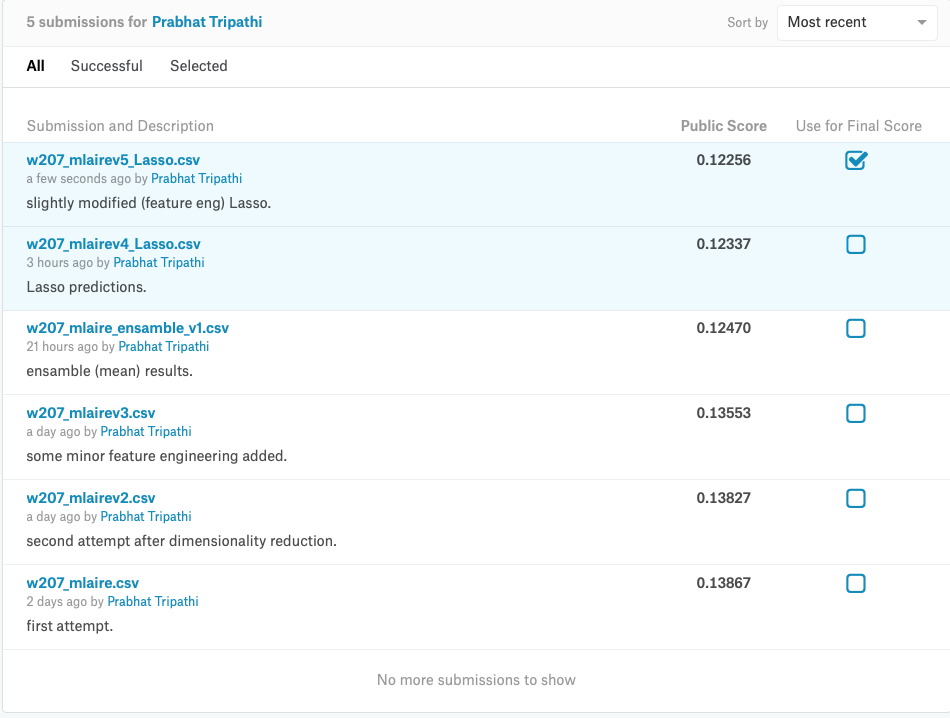

In [89]:
from IPython.display import Image
Image(filename='kaggle_submissions.png', width=800)

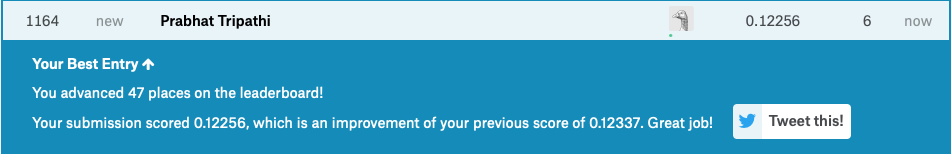

In [90]:
Image(filename='kaggle_rank.png', width=800)

<a id='references'></a>
# 8. References

[1]: <a href="https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c">L1 and L2 Regularization Model</a><br>
[2]: <a href="https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/">Effect of Alpha on Lasso Regression</a><br>